In [7]:
import pickle
import warnings
from collections import Counter
from pathlib import Path
from string import punctuation
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy as spc
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import spectral_embedding
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP

nlp = spc.load("en_core_web_sm", disable=["ner", "parser", "tagger"])

seed = 42
np.random.seed(seed)

In [8]:
dataset = fetch_20newsgroups(subset="all", random_state=seed, remove=("headers", "footers"), shuffle=True)
corpus = dataset.data
y = dataset.target
y_labels = dataset.target_names
n_labels = len(np.unique(y_labels))
print(f"unique labels: {n_labels}")

unique labels: 20


In [9]:
def is_token_bad(token):
    return token.is_stop or token.is_punct or token.like_email or token.is_bracket or token.is_quote or \
           token.is_currency or token.like_num or token.is_space or token.like_url

path_to_preprocessed_corpus = "preprocessed_corpus.pkl"
if Path(path_to_preprocessed_corpus).is_file():
    with open(path_to_preprocessed_corpus, "rb") as f:
        preprocessed_corpus = pickle.load(f)
else:
    preprocessed_corpus = []
    for i, text in enumerate(corpus):
        doc = nlp(text.lower())
        text = " ".join([
            token.lemma_.strip(punctuation) for token in doc if not is_token_bad(token) and token.lemma_ != "-PRON-"
        ])
        doc = nlp(text)
        preprocessed_corpus.append([
            token.lemma_.strip() for token in doc if not is_token_bad(token) and token.lemma_.isalpha()
        ])
    with open(path_to_preprocessed_corpus, "wb") as f:
        pickle.dump(preprocessed_corpus, f)

In [10]:
lda_path = datapath("lda_model")
dictionary = Dictionary(preprocessed_corpus)
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_corpus]

if not Path(lda_path).exists():
    lda = LdaModel(bow_corpus, num_topics=20, id2word=dictionary, passes=10)
    lda.save(lda_path)
else:
    lda = LdaModel.load(lda_path)

In [11]:
lda_embedding = []
for topics in lda.get_document_topics(bow_corpus, minimum_probability=0):
    lda_embedding.append([topic[1] for topic in sorted(topics, key=lambda x: x[0])])
lda_embedding = pd.DataFrame(lda_embedding)
print(lda_embedding.shape)

# for row in lda_embedding:
#     print(row)

(18846, 20)


In [12]:
lda_embedding_2d = UMAP(
    n_components=2, n_neighbors=30, min_dist=0.0, random_state=seed, transform_seed=seed
).fit_transform(lda_embedding)

In [13]:
lda_clusters = KMeans(
    n_clusters=20, random_state=seed, n_jobs=-1
).fit_predict(lda_embedding_2d)

# lda_clusters = HDBSCAN(
#     min_samples=1, min_cluster_size=50, core_dist_n_jobs=-1
# ).fit_predict(lda_embedding_2d)

lda_counter = Counter(lda_clusters)
n_lda_clusters = len(np.unique(lda_clusters))
print(f"lda embedding clusters: {n_lda_clusters - 1 if -1 in np.unique(lda_clusters) else n_lda_clusters}")
print(f"lda embedding cluster sizes: {sorted(lda_counter.items(), key=lambda x: x[1], reverse=True)}")
print(f"lda embedding noise level: {np.round(lda_counter[-1] / len(lda_clusters), 3)}")

lda embedding clusters: 20
lda embedding cluster sizes: [(3, 1797), (5, 1496), (9, 1290), (4, 1259), (8, 1140), (17, 1066), (7, 1021), (10, 1009), (18, 976), (15, 900), (1, 891), (11, 832), (6, 820), (0, 815), (16, 798), (13, 776), (2, 752), (14, 696), (12, 445), (19, 67)]
lda embedding noise level: 0.0


In [14]:
y_lda_wo_noise = [y[i] for i in range(len(y)) if lda_clusters[i] != -1]
lda_clusters_wo_noise = [cluster for cluster in lda_clusters if cluster != -1]

print(f"lda embedding AMI: {adjusted_mutual_info_score(y_lda_wo_noise, lda_clusters_wo_noise)}")
print(f"lda embedding ARI: {adjusted_rand_score(y_lda_wo_noise, lda_clusters_wo_noise)}")

lda embedding AMI: 0.4670681146799233
lda embedding ARI: 0.30706145954373787


In [15]:
palette = plt.cm.Set3.colors \
          + plt.cm.Set2.colors[5:7] \
          + plt.cm.tab10.colors[:-1] \
          + tuple(plt.cm.tab20c.colors[i] for i in [4]) \
          + tuple(plt.cm.tab20b.colors[i] for i in [0, 4, 8, 12, 16]) \
          + plt.cm.tab10.colors[-1:]

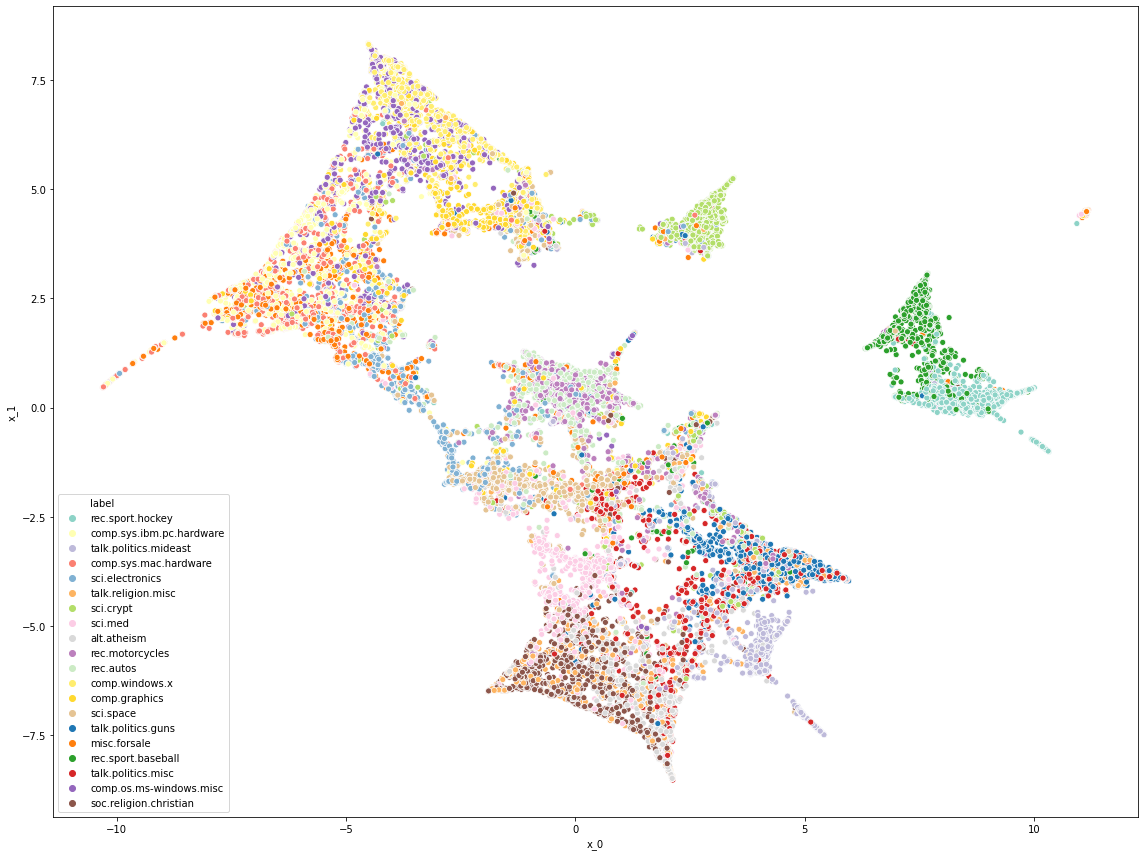

In [16]:
data = {
    "x_0": lda_embedding_2d[:, 0], 
    "x_1": lda_embedding_2d[:, 1], 
    "label": [y_labels[i] for i in y],
    "clusters": lda_clusters
}

plt.figure(figsize=(16, 12))
sns.scatterplot(x="x_0", y="x_1", hue="label", data=pd.DataFrame(data), palette=sns.color_palette(palette, n_labels))
plt.tight_layout()
plt.show()

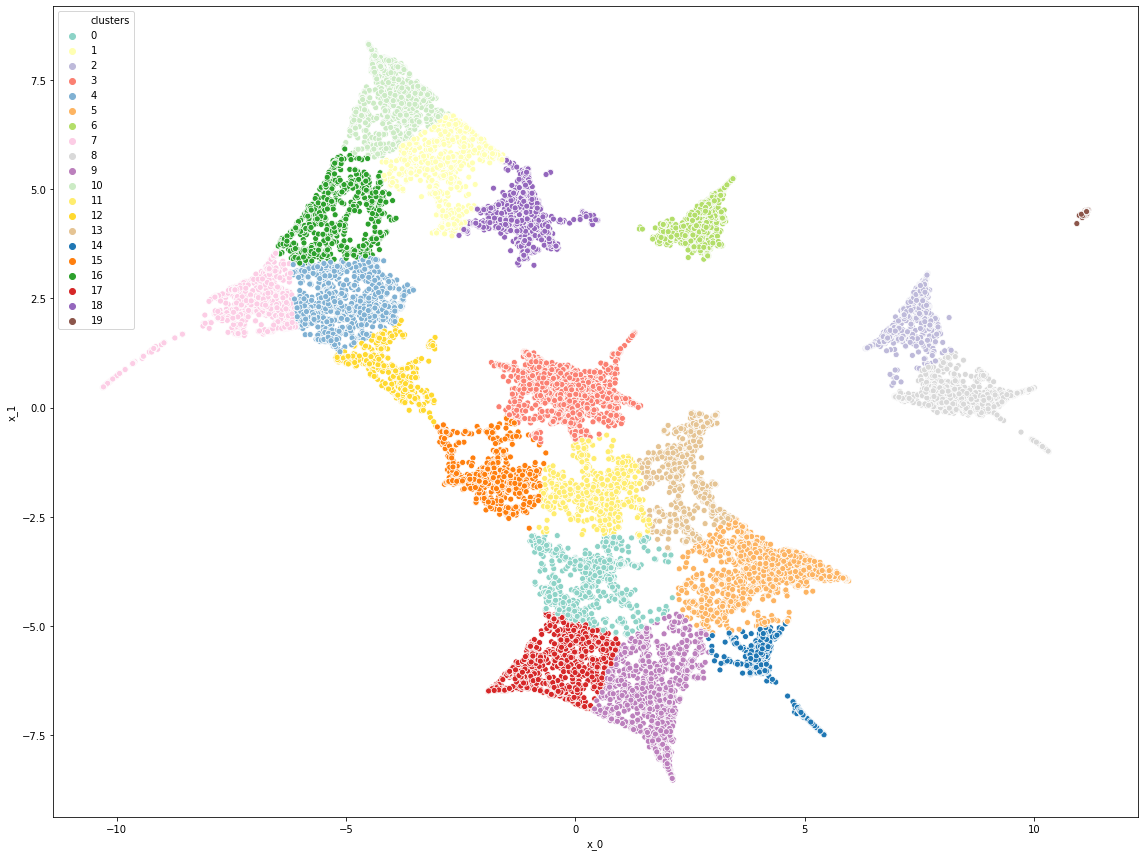

In [17]:
plt.figure(figsize=(16, 12))
sns.scatterplot(
    x="x_0", y="x_1", hue="clusters", data=pd.DataFrame(data), palette=sns.color_palette(palette, n_lda_clusters)
)
plt.tight_layout()
plt.show()

In [18]:
path_to_spectral_embedding = "spectral_embedding.pkl"

if Path(path_to_spectral_embedding).is_file():
    with open(path_to_spectral_embedding, "rb") as f:
        spectral_embedding_ = pickle.load(f)
else:
    vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, min_df=1)
    tfidf_doc_term_matrix = vectorizer.fit_transform(preprocessed_corpus)
    print(tfidf_doc_term_matrix.shape)

    similarity_matrix = cosine_similarity(tfidf_doc_term_matrix)
    
    spectral_embedding_ = spectral_embedding(
        similarity_matrix, n_components=40, drop_first=False, random_state=seed
    )
    with open(path_to_spectral_embedding, "wb") as f:
        pickle.dump(spectral_embedding_, f)

print(spectral_embedding_.shape)

(18846, 64701)
(18846, 40)


In [19]:
spectral_embedding_df = pd.DataFrame(spectral_embedding_)
first_ev = spectral_embedding_df[0].values.round(10)
first_ev_counter = Counter(first_ev)
largest_cc_value = first_ev_counter.most_common(1)[0][0]
spectral_embedding_largest_cc_idxs = first_ev == largest_cc_value
spectral_embedding_largest_cc_df = spectral_embedding_df[spectral_embedding_largest_cc_idxs]
# spectral_embedding_largest_cc_df = spectral_embedding_df
print(spectral_embedding_largest_cc_df.shape)

y_spectral_df = pd.DataFrame(y)[spectral_embedding_largest_cc_idxs]
# y_spectral_df = pd.DataFrame(y)
print(y_spectral_df.shape)

(18795, 40)
(18795, 1)


In [20]:
spectral_embedding_2d = UMAP(
    n_components=2, n_neighbors=30, min_dist=0.0, random_state=seed, transform_seed=seed
).fit_transform(spectral_embedding_largest_cc_df.values)

In [21]:
# spectral_clusters = KMeans(
#     n_clusters=20, random_state=seed, n_jobs=-1
# ).fit_predict(spectral_embedding_2d)

spectral_clusters = HDBSCAN(
    min_samples=1, min_cluster_size=220, core_dist_n_jobs=-1
).fit_predict(spectral_embedding_2d)

spectral_counter = Counter(spectral_clusters)
n_spectral_clusters = len(np.unique(spectral_clusters))
print(
    f"spectral embedding clusters: "
    f"{n_spectral_clusters - 1 if -1 in np.unique(spectral_clusters) else n_spectral_clusters}"
)
print(f"spectral embedding cluster sizes: {sorted(spectral_counter.items(), key=lambda x: x[1], reverse=True)}")
print(f"spectral embedding noise level: {np.round(spectral_counter[-1] / len(spectral_clusters), 3)}")

spectral embedding clusters: 27
spectral embedding cluster sizes: [(-1, 2344), (0, 1818), (23, 1548), (26, 872), (2, 757), (18, 713), (5, 705), (8, 664), (25, 647), (3, 637), (14, 607), (9, 605), (19, 577), (7, 552), (21, 548), (13, 526), (12, 512), (22, 503), (11, 499), (1, 484), (16, 442), (15, 400), (24, 390), (17, 380), (6, 318), (4, 252), (10, 250), (20, 245)]
spectral embedding noise level: 0.125


In [22]:
y_spectral_wo_noise = y_spectral_df[spectral_clusters != -1].values.flatten()
spectral_clusters_wo_noise = [cluster for cluster in spectral_clusters if cluster != -1]

print(f"spectral embedding AMI: {adjusted_mutual_info_score(y_spectral_wo_noise, spectral_clusters_wo_noise)}")
print(f"spectral embedding ARI: {adjusted_rand_score(y_spectral_wo_noise, spectral_clusters_wo_noise)}")

spectral embedding AMI: 0.5218669902983469
spectral embedding ARI: 0.39240061187594005


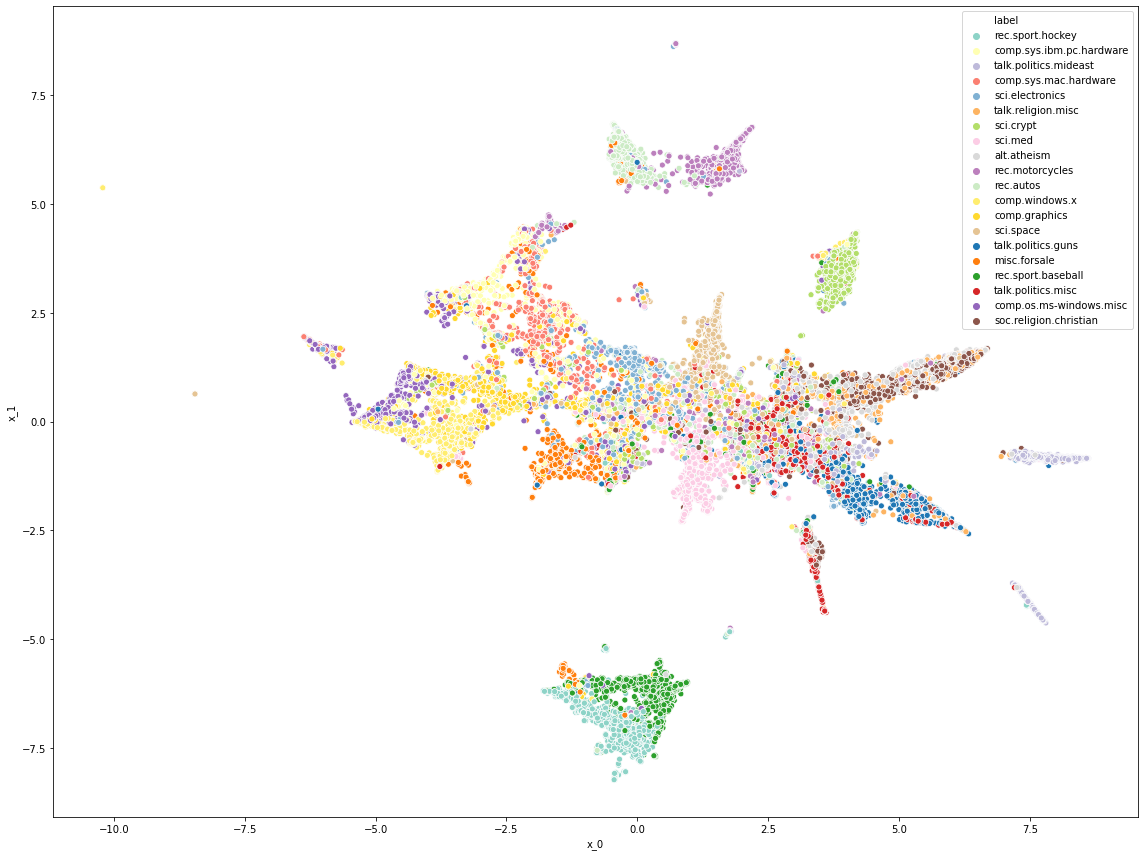

In [23]:
data = {
    "x_0": spectral_embedding_2d[:, 0], 
    "x_1": spectral_embedding_2d[:, 1], 
    "label": [y_labels[i] for i in y_spectral_df.values.astype(np.uint8).flatten()],
    "clusters": spectral_clusters
}

plt.figure(figsize=(16, 12))
sns.scatterplot(x="x_0", y="x_1", hue="label", data=pd.DataFrame(data), palette=sns.color_palette(palette, n_labels))
plt.legend()
plt.tight_layout()
plt.show()

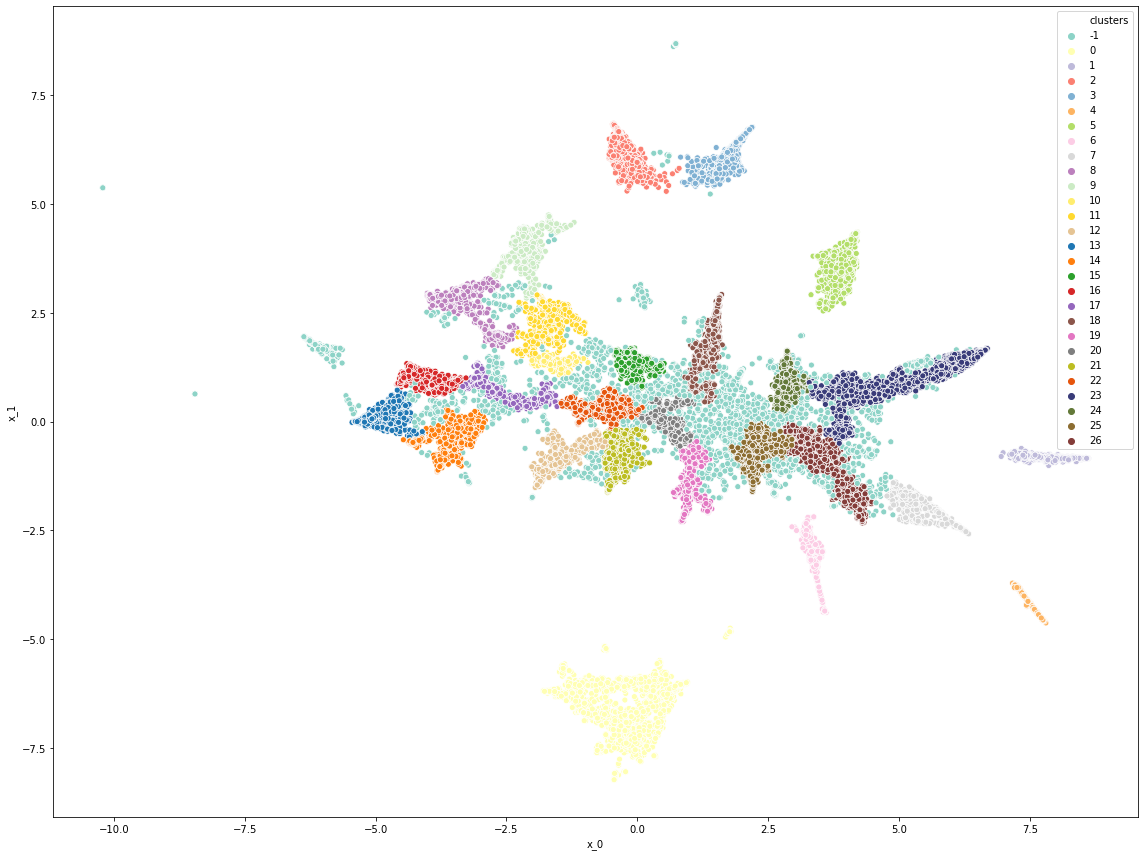

In [26]:
plt.figure(figsize=(16, 12))
sns.scatterplot(
    x="x_0", y="x_1", hue="clusters", data=pd.DataFrame(data), palette=sns.color_palette(palette, n_spectral_clusters)
)
plt.tight_layout()
plt.show()